# Implementing a simple RAG pipeline
In this notebook, we will be implementing a simple RAG pipeline using LangChain library. Our RAG system's purpose is to answer student's questions about course offerings in Sabanci University.

This notebook was prepared using some of the material from these two sources:
* [Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/rag_zephyr_langchain.ipynb#scrollTo=Kih21u1tyr-I)
* [Advanced RAG on Hugging Face documentation using LangChain](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/advanced_rag.ipynb#scrollTo=VjVqmDGh9-9N)

In [ ]:
# Downloading relevant libraries
!pip install -q torch transformers accelerate bitsandbytes transformers sentence-transformers langchain-chroma langchain langchain-community langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Loading Data
The data we will be using was scraped from the [Sabanci Student Information system](https://suis.sabanciuniv.edu/prod/bwckschd.p_disp_dyn_sched).

In [ ]:
!gdown https://drive.google.com/uc?id=1oNPMb2rzlPd3HOi64k1Nz4uOhPnYshAs
!unzip -q /content/sabanci_course_docs.zip

Downloading...
From: https://drive.google.com/uc?id=1oNPMb2rzlPd3HOi64k1Nz4uOhPnYshAs
To: /content/sabanci_course_docs.zip
100% 27.9k/27.9k [00:00<00:00, 49.9MB/s]


LangChain provides document loaders that allow loading different types of data such as:
* Text
* PDF
* HTML
* CSV
* Markdown
* File Directory

You can check all these loaders [here](https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/). Since our data is text files, we will use the `TextLoader`.

In [ ]:
# Loading data
from langchain_community.document_loaders import TextLoader
import glob

docs = []
for file in glob.glob("/content/sabanci_course_docs/*.txt"):
  loader = TextLoader(file)
  docs += loader.load()

print(f"No. Documents: {len(docs)}")

No. Documents: 8


In [ ]:
# Checking document lengths
print([len(doc.page_content) for doc in docs])

[71871, 4711, 65417, 6082, 47612, 99484, 49036, 93912]


## Processing documents


  <div>
  <img src="https://drive.google.com/uc?export=view&id=1y_9TBlqTeVDdLUanNmVulQWrzs0A1OgO" width="500"/>
  </div>

[Image source](https://www.linkedin.com/pulse/ragparadigm-mohamed-azharudeen/)

Now that we have the documents loaded as text, we need to split them to small chunks (**Why?** *Because we want to create a database of text-chunk-embeddings that will be used to find the parts of the document that are relevant to the user query*). When splitting documents into chunks, we need to take into consideration several factors:
1. **Maximum chunk length**: This depends on:
  * **Embedding model**: The length of each chunk should not exceed the maximum sequence length of the model that is used to create the embeddings of the document chunks.
  * **Generative model**: Since we will be passing $k$ of the document chunks as context to the generative LLM, we need to make sure that the maximum sequence length of the generative LLM allows for fitting the prompt template, the context ($k$ document chunks), the query, and the model response.

2. **Semantic content in chunks**: Ideally, we want each chunk to have a specific information content so that we can easily match it with the user query. However, it is hard to control the semantic content of the chunk since we are automatically splitting the documents. Having very large chunks will result in several ideas being covered in the same chunk, which will force the embedding to represent all these ideas, making it harder to match it with the user query. The choice on how to split the document into chunks highly depends on the type of documents.

The LangChain `text_splitter` module provides several utilities for splitting the text into smaller chunks ([link](https://python.langchain.com/docs/modules/data_connection/document_transformers)).

1. **Split by character using `CharacterTextSplitter`:**
This is the simplest method. It splits using a specific character defined by the user, such as `\n`. The user also defines a `chunk_size` parameter as an upper bound to the chunk size. `CharacterTextSplitter` splits the text using the defined character and keeps merging until it gets the longest text that does not excced the defined `chunk_size`. However, if a part of the splitted text exceeds the `chunk_size` it does not split it any further, resulting in a chunk that is longer than the maximum `chunk_size`.

The `chunk_overlap` argument allows for keeping an overlap between chunks. Since we are not sure that each chunk captures a specific meaning in the document, having an overlap between chunks increases the chances of capturing the semantic meanings in one chunk.

2. **Recursively split by character `RecursiveCharacterTextSplitter`**: This solves the problem of the first splitter by allowing splits using the more than one character. Ex: we can first split paragraphs, then if a paragraph exceeds the maximum `chunk_size` we split by sentences, and finally we split by words if necessary. This way we can ensure to meet the `chunk_size` limit.

Check [this site](https://chunkviz.up.railway.app/) to see how the different parameters of a `text_splitter` work.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=30,
    separators=["\n\n", "\n"]
    )

chunked_docs = splitter.split_documents(docs)

print(f"No. Chunks: {len(chunked_docs)}")

No. Chunks: 371


In [ ]:
print(chunked_docs[0].page_content)

Economics courses
Games and Strategies - 10229 - ECON 201 - A
Associated Term: Fall 2023-2024 
Registration Dates:  No dates available  
Levels: Doctorate, Undeclared, Scientific Preparatory, Undergraduate, Masters, Special Student, Exchange - Socrates Erasmus UG, Exchange - Erasmus Mundus MA, Exchange - Erasmus Mundus DR, Exchange - Erasmus Mundus UG 
Faculty: 
Course Offered by FASS
Attributes: Lang. of Instruction: English, 6 ECTS, Course Offered by FASS 
Sabancı University Campus Campus
Lecture Schedule Type
       3.000 Credits
|    | Type   | Time              | Days   | Where                                  | Date Range                  | Schedule Type   | Instructors        |
|---:|:-------|:------------------|:-------|:---------------------------------------|:----------------------------|:----------------|:-------------------|
|  0 | Class  | 1:40 pm - 2:30 pm | M      | Fac.of Arts and Social Sci. 1001-1001A | Oct 02, 2023 - Jan 05, 2024 | 2nd del         | Özgür   Kıbrıs (P

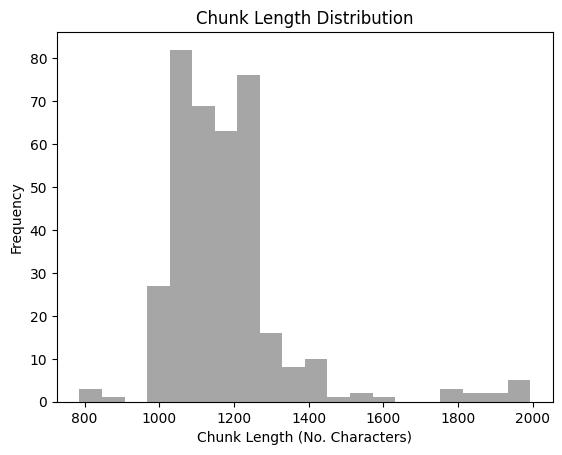

In [ ]:
# Let us visualize the length of the chunks distribution

len_arr = [len(chunk.page_content) for chunk in chunked_docs]
plt.hist(len_arr, color="gray", alpha=0.7, bins=20)
plt.title("Chunk Length Distribution")
plt.xlabel("Chunk Length (No. Characters)")
plt.ylabel("Frequency")
plt.show()

How can we make sure that the chunk lengths are suitable for the mbedding model? **We need to measure their length by token length**. The embedding model that we will be using accepts a maximum of 512 tokens.

In [ ]:
from transformers import AutoTokenizer

embedding_model_id = 'BAAI/bge-base-en-v1.5'

tokenizer = AutoTokenizer.from_pretrained(embedding_model_id)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Tokenizer reminder
text = "Hello this is a textual message"
token_ids = tokenizer.encode(text)
tokenizer.convert_ids_to_tokens(token_ids)

['[CLS]', 'hello', 'this', 'is', 'a', 'textual', 'message', '[SEP]']

In [ ]:
def get_num_tokens(text):
  return len(tokenizer.encode(text))

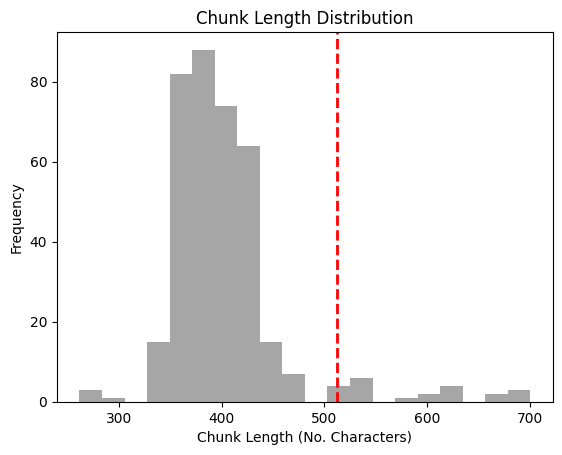

In [ ]:
len_arr = [get_num_tokens(chunk.page_content) for chunk in chunked_docs]
plt.hist(len_arr, color="gray", alpha=0.7, bins=20)
plt.axvline(512, color="red", linestyle="--", lw=2)
plt.title("Chunk Length Distribution")
plt.xlabel("Chunk Length (No. Characters)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=30,
    separators=["\n\n", "\n"],
    length_function=get_num_tokens
    )

chunked_docs = splitter.split_documents(docs)

print(f"No. Chunks: {len(chunked_docs)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


No. Chunks: 393


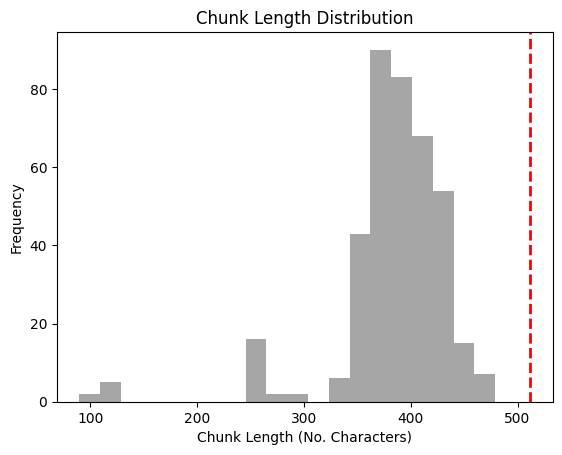

In [ ]:
len_arr = [get_num_tokens(chunk.page_content) for chunk in chunked_docs]
plt.hist(len_arr, color="gray", alpha=0.7, bins=20)
plt.axvline(512, color="red", linestyle="--", lw=2)
plt.title("Chunk Length Distribution")
plt.xlabel("Chunk Length (No. Characters)")
plt.ylabel("Frequency")
plt.show()

## Text embedding
* Extensive introduction to sentence embeddings
* [Text Embedding - LangChain](https://python.langchain.com/docs/modules/data_connection/text_embedding/)
* Follow the steps here to get an API key to use Google Gemini: [Google Gemini quick start](https://ai.google.dev/tutorials/python_quickstart)

Now that we have divided our text into chunks, we need to pass these chunks into an embedding model to get their respective embeddings. We can use any LLM that provides embeddings to sentences. This includes models on the cloud accessible through API, such as OpenAI ChatGPT and Google Gemini, or local models. You can see the models supported by the LangChain library [here](https://python.langchain.com/docs/integrations/text_embedding). The choice of the embedding model is usually limited by the following factors:
* **Privacy concerns:** If we are dealing with private data, regulations may not allow us to send the data to commercial LLM services such as ChatGPT or Gemini.
* **Available computational power:** If we opt to use local models, we need to choose a model that can be run on the available hardware.
* **Latency:** Which is the time required to process a query and generate embeddings. See this article for more details on the latency of LLMs ([link](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices)).
* **Context length**: Which is the maximum number of tokens that a model can process. This is more of a concern for the generating LLm rather than the embedding LLM since we usually embed the documents at the sentence level.

1. **Using LLM API**

Check [tutorial](https://ai.google.dev/tutorials/python_quickstart) on how to setup and use Gemini API.

In [ ]:
!pip install -q -U langchain-google-genai
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.2/164.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 46.8 MB/s eta 0:00:00


In [ ]:
import google.generativeai as genai
from google.colab import userdata
import os

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

LangChain provides wrappers for several embedding models. Each of these classes have the methods `embed_query` and `embed_document` to compute embeddings for queries and documents, respectively.

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Computing query embeddings
vector = embedding_model.embed_query("hello, world!")
print(len(vector))
vector[:5]

768


[0.05168594419956207,
 -0.030764883384108543,
 -0.03062233328819275,
 -0.02802734449505806,
 0.01813092641532421]

In [ ]:
# Example
query = "What is the capital of America?"
chunks = [
    "Washington D.C. is the capital of the USA",
    "Rates of return on invested capital were high",
    "American football is popular in India",
    "The White House is in Washington, D.C.",
    "Cats are better pets than dogs"
]

query_embedding = embedding_model.embed_query(query)
chunk_embeddings = embedding_model.embed_documents(chunks)

In [ ]:
# Computing similarities
from sklearn.metrics.pairwise import cosine_similarity

for chunk, chunk_embedding in zip(chunks, chunk_embeddings):
  similarity = cosine_similarity([query_embedding], [chunk_embedding])[0][0]
  print(f"{chunk}: {similarity:.3f}")

Washington D.C. is the capital of the USA: 0.727
Rates of return on invested capital were high: 0.498
American football is popular in India: 0.570
The White House is in Washington, D.C.: 0.616
Cats are better pets than dogs: 0.507


2. **Using a local model:**

For the local model, we will use Sentence-BERT ([link to original paper](https://arxiv.org/abs/1908.10084)) to generate embeddings. Several pretrained models of this structure are provided through the `sentence_transformers` library ([link to documentation](https://www.sbert.net/)).

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding_model_id = 'BAAI/bge-base-en-v1.5'

embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_id, model_kwargs={'device': 'cuda'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Example
query = "What is the capital of America?"
chunks = [
    "Washington D.C. is the capital of the USA",
    "Rates of return on invested capital were high",
    "American football is popular in India",
    "The White House is in Washington, D.C.",
    "Cats are better pets than dogs"
]

query_embedding = embedding_model.embed_query(query)
chunk_embeddings = embedding_model.embed_documents(chunks)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for chunk, chunk_embedding in zip(chunks, chunk_embeddings):
  similarity = cosine_similarity([query_embedding], [chunk_embedding])[0][0]
  print(f"{chunk}: {similarity:.3f}")

Washington D.C. is the capital of the USA: 0.820
Rates of return on invested capital were high: 0.396
American football is popular in India: 0.447
The White House is in Washington, D.C.: 0.635
Cats are better pets than dogs: 0.408


In [ ]:
# Checking maximum sequence length
embedding_model.client.get_max_seq_length()

512

## Vector Stores
Now that we have created embeddings for the document chunks, we need to store them in a database that allows us to quickly retrieve the most similar text chunk embeddings to a given query embedding. A vector store is a database type that is used to save high dimensional numerical vectors, i.e., embeddings. These databases allow for very fast retrieval of the most similar $k$ vectors to a query vector. The speed of retrieval is attributed to the usage of approximate nearest neighbour (ANN) alogorithms rather than the expensive K-nearest neighbour algorithm.

LangChain integrates several open-source vector stores ([link](https://python.langchain.com/docs/modules/data_connection/vectorstores/)).

In [ ]:
from langchain_chroma import Chroma

db = Chroma.from_documents(chunked_docs, embedding_model)

In [ ]:
# Creating retriever
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 6}
)

In [ ]:
relevant_docs = retriever.invoke("Who is the instructor of the Intro to Data Science course in Fall 2023?")
print(relevant_docs[0].page_content)

Computer Science courses
Introduction to Data Science Recitation - 10093 - CS 210R - D
Associated Term: Fall 2023-2024 
Registration Dates:  No dates available  
Levels: Doctorate, Undeclared, Scientific Preparatory, Undergraduate, Masters, Special Student, Exchange - Socrates Erasmus UG, Exchange - Socrates Erasmus MA, Exchange - Socrates Erasmus DR, Exchange - Erasmus Mundus MA, Exchange - Erasmus Mundus DR, Exchange - Erasmus Mundus UG 
Faculty: 
Course Offered by FENS
Attributes: Lang. of Instruction: English, Course Offered by FENS 
Sabancı University Campus Campus
Recitation Schedule Type
       0.000 Credits
|    | Type   | Time              | Days   | Where                             | Date Range                  | Schedule Type   | Instructors                                                                             |
|---:|:-------|:------------------|:-------|:----------------------------------|:----------------------------|:----------------|:-----------------------------

## Generative model
The final step is to have a generative LLM that we can chat with. In this tutorial we will use Google's Gemini model. You can check the API rate limits and pricing [here](https://ai.google.dev/pricing).

In [ ]:
import google.generativeai as genai

for model in genai.list_models():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision
models/embedding-001
models/text-embedding-004
models/aqa


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

model_id = "models/gemini-1.5-flash"
llm = ChatGoogleGenerativeAI(model=model_id)
result = llm.invoke("What is RAG?")
print(result.content)

RAG stands for **Retrieval-Augmented Generation**. It's a technique used in natural language processing (NLP) that combines the power of information retrieval with the capabilities of language models. 

Here's how it works:

1. **Retrieval:** The system first retrieves relevant information from a large knowledge base (like a database or a corpus of text) based on a user's query or prompt.
2. **Augmentation:** This retrieved information is then used to augment the input to a language model.
3. **Generation:** The language model uses the augmented input to generate a more informative and accurate response.

**Benefits of RAG:**

* **Improved Accuracy:** By incorporating relevant information from external sources, RAG models can provide more accurate and reliable responses.
* **Enhanced Contextual Understanding:** RAG systems can access and understand the context of a query, leading to more relevant and nuanced answers.
* **Factual Consistency:** Retrieval-based augmentation helps ensure 

In [ ]:
# Asking about courses at Sabanci

result = llm.invoke("Who teaches the Deep Learning graduate course at sabanci university?")
print(result.content)

I do not have access to real-time information, including specific course details and instructors at universities. 

To find out who teaches the Deep Learning graduate course at Sabancı University, I recommend you:

1. **Visit the Sabancı University website:** Look for the Computer Science or related department page. They usually have course listings with instructors.
2. **Contact the department directly:** You can reach out to the Computer Science department at Sabancı University via email or phone and inquire about the Deep Learning course and its instructor.

I hope this helps! 



## Final RAG pipeline


In [ ]:
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

prompt_template = """
You are an assistant that helps the students of Sabanci University to learn about the offered courses.
Use the information below to answer the student's question.

Relevant Information:
{context}

Question:
{question}
 """

prompt_generator = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

In [ ]:
prompt = prompt_generator.invoke({"context": "This is a relevant document", "question": "This is the user question?"})
print(prompt.text)


You are an assistant that helps the students of Sabanci University to learn about the offered courses.
Use the information below to answer the student's question.

Relevant Information:
This is a relevant document

Question:
This is the user question?
 


### RAG Chain
LangChain allows chaining several components into one pipeline using a simple syntax. The input to the chain is processed by each part of the chain and then passed to the next part. In our case, the processing order is:

1. The user query is sent to the `retriever` to get relevant documents.
2. The documents are passed through the `format_docs` to convert them into one string.
3. The question is passed through `RunnablePassthrough()`, which just takes the input and passes it to the next part of the chain. We use it here to pass the user query to the prompt generator. At this point, we have the input to the prompt generator ready (context + question).
4. The context and question are sent to the prompt generator, which place them into the prompt template that we defined.
5. The prompt is sent to the LLM
6. The output of the LLM is parsed using `StrOutputParser()`.


In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()} # Steps 1, 2, 3
    | prompt_generator # Step 4
    | llm # Step 5
    | StrOutputParser() # Step 6
)

In [ ]:
import textwrap

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
question = "When are the CS 514 course classes? Who teaches the course?"
# question = "Suggest me some economics courses in Fall 2023 on Mondays"
# question = "Are there any machine learning courses offered in Fall 2023?"
# question = "What is the best lab in Sabanci University?"

output = rag_chain.invoke(question)
to_markdown(output)

> The CS 514 (Network Science) course has classes on Mondays from 2:40 pm to 4:30 pm and Wednesdays from 12:40 pm to 1:30 pm. The course is taught by Onur Varol. 
